In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns

from aiutils import load

In [109]:
SMALL_SIZE = 11
MEDIUM_SIZE = 13
BIGGER_SIZE = 15

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
sandbox_colors_map = {'Copper': '#b87333', 'Curse': '#a47abb','Estate': '#9dd57d', 'Duchy': '#81a566', 'Province': '#3a923d', 'Silver': '#c0c0c0', 'Gold': '#ffd700'}
sandbox_colors = [v for v in sandbox_colors_map.values()]

In [5]:
project_root = '/home/justiny/Documents/Projects/PyDominion'
# project_root = '/home/justiny/Princeton/PyDominion'
model_dir = os.path.join(project_root, 'models')
fig_dir = '/home/justiny/Documents/Projects/Thesis/dominion-thesis/figures'
dpi=300

In [6]:
idx = pd.IndexSlice

In [9]:
colors = ['#f58025', '#000000']
pu_oj = colors[0]
blk = colors[-1]

In [6]:
# Multi-index of first card buy
def first_card_idxs(df, card):
    temp = df[df['Card'] == card][['Iter', 'Turn']].groupby('Iter').min()
    return temp.reset_index().set_index(['Iter', 'Turn']).index

In [55]:
df = sim_stats.turn_df
df['Count'] = df.groupby(['Iter', 'Player', 'Card']).cumcount() + 1

player_df = sim_stats.player_df

game_df = sim_stats.game_df

n = len(game_df)

p0_df, p1_df = df[df['Player']==0], df[df['Player']==1]
p0_game_df, p1_game_df = player_df[player_df['Player']==0].reset_index(drop=True), player_df[player_df['Player']==1].reset_index(drop=True)

In [58]:
df['Game Progress'] = df[['Iter', 'Player', 'Turn']].groupby(['Iter', 'Player']).transform(lambda z: z.div(z.max()))

In [22]:
# Indices of pure win/loss/tie games
p_win_idxs = p0_game_df[(p0_game_df['Won'] == True) & (game_df['Tie'] == False)].index
p_loss_idxs = p0_game_df[(p0_game_df['Won'] == False) & (game_df['Tie'] == False)].index
tie_idxs = p0_game_df[game_df['Tie'] == True].index

assert len(p_win_idxs) + len(p_loss_idxs) + len(tie_idxs) == n

# Indices of win (pure win + tie) / loss (pure loss + tie) games
win_idxs = p_win_idxs.union(tie_idxs)
loss_idxs = p_loss_idxs.union(tie_idxs)

assert len(p_win_idxs) + len(loss_idxs) == n

# Indices of games where starting player gets extra turn or not
eq_turn_idxs = p0_game_df[p0_game_df['Turns'] == p1_game_df['Turns']].index 
neq_turn_idxs = p0_game_df[p0_game_df['Turns'] == p1_game_df['Turns'] + 1].index 

assert len(eq_turn_idxs) + len(neq_turn_idxs) == n

tie_loss_idxs = neq_turn_idxs.intersection(tie_idxs)
fair_loss_idxs = p_loss_idxs.union(tie_loss_idxs)

# Multi-index of last turn in each game
last_turn_idxs_df = (p0_df[['Iter', 'Turn']].groupby('Iter').max())['Turn']
last_turn_idxs = list(zip(last_turn_idxs_df.index, last_turn_idxs_df))

# Multi-index of penultimate turn in each game
penult_turn_idxs_df = (p0_df[['Iter', 'Turn']].groupby('Iter').max() - 1)['Turn']
penult_turn_idxs = list(zip(penult_turn_idxs_df.index, penult_turn_idxs_df))

# Indices of non-upper-tail games
non_utail_idxs = game_df[game_df['Turns'] <= 20].index

## Dominion ##

### Performance Analysis ###

In [19]:
dataset_name = 'uct25-dw25-1k-data'
data_path = os.path.join(project_root, 'data', dataset_name)
uct25_dw25_data = load(data_path)
uct25_dw25_turns = uct25_dw25_data.turn_df
uct25_dw25_cards = uct25_dw25_data.card_df

dataset_name = 'uct25-dw34-1k-data'
data_path = os.path.join(project_root, 'data', dataset_name)
uct25_dw34_data = load(data_path)
uct25_dw34_turns = uct25_dw34_data.turn_df
uct25_dw34_cards = uct25_dw34_data.card_df

dataset_name = 'uct34-dw25-1k-data'
data_path = os.path.join(project_root, 'data', dataset_name)
uct34_dw25_data = load(data_path)
uct34_dw25_turns = uct34_dw25_data.turn_df
uct34_dw25_cards = uct34_dw25_data.card_df

dataset_name = 'uct34-dw34-1k-data'
data_path = os.path.join(project_root, 'data', dataset_name)
uct34_dw34_data = load(data_path)
uct34_dw34_turns = uct34_dw34_data.turn_df
uct34_dw34_cards = uct34_dw34_data.card_df

In [21]:
dataset_name = 'dw25-uct25-1k-data'
data_path = os.path.join(project_root, 'data', dataset_name)
dw25_uct25_data = load(data_path)
dw25_uct25_turns = dw25_uct25_data.turn_df
dw25_uct25_cards = dw25_uct25_data.card_df

dataset_name = 'dw34-uct25-1k-data'
data_path = os.path.join(project_root, 'data', dataset_name)
dw34_uct25_data = load(data_path)
dw34_uct25_turns = dw34_uct25_data.turn_df
dw34_uct25_cards = dw34_uct25_data.card_df

dataset_name = 'dw25-uct34-1k-data'
data_path = os.path.join(project_root, 'data', dataset_name)
dw25_uct34_data = load(data_path)
dw25_uct34_turns = dw25_uct34_data.turn_df
dw25_uct34_cards = dw25_uct34_data.card_df

dataset_name = 'dw34-uct34-1k-data'
data_path = os.path.join(project_root, 'data', dataset_name)
dw34_uct34_data = load(data_path)
dw34_uct34_turns = dw34_uct34_data.turn_df
dw34_uct34_cards = dw34_uct34_data.card_df

In [11]:
decks = dw25_uct25_cards.melt(id_vars=['Iter', 'Player', 'Turn'], var_name='Card', value_name='Count')

In [28]:
exclude = ['Curse', 'Silver', 'Gold', 'Copper', 'Estate', 'Duchy','Province']

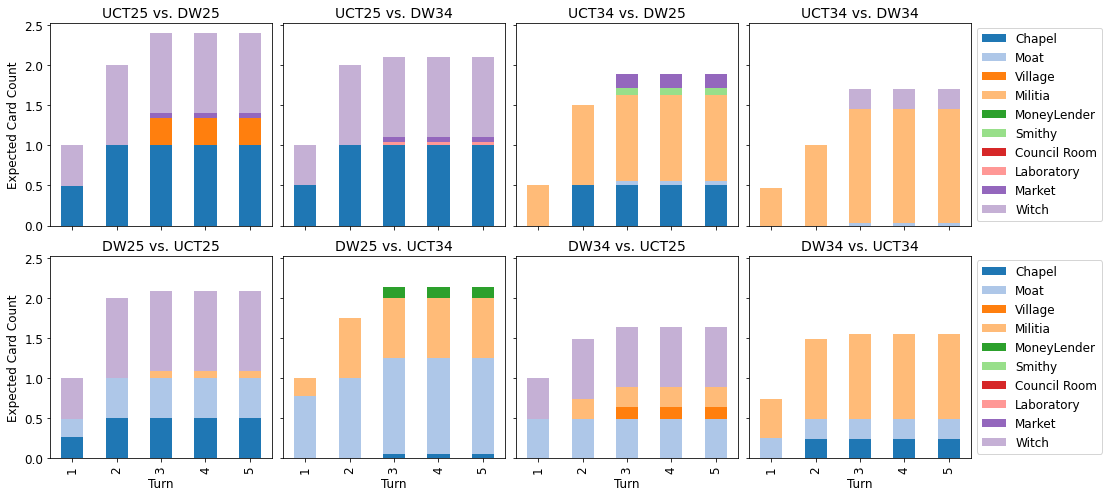

In [80]:
sns.set_palette('tab20')

data = [[uct25_dw25_cards, uct25_dw34_cards, uct34_dw25_cards, uct34_dw34_cards], [dw25_uct25_cards, dw25_uct34_cards, dw34_uct25_cards, dw34_uct34_cards]]
n, m = len(data), len(data[0])

fig, axes = plt.subplots(n, m, figsize=(16.5, 8), sharex='all', sharey='all')

for i in range(n):
    for j in range(m):
        mean_counts = data[i][j].groupby(['Player', 'Turn']).mean()
        plot_data = mean_counts.loc[idx[i, [1, 2, 3, 4, 5]], :].reset_index().drop(exclude + ['Iter', 'Player'], axis=1)
        plot_data.plot(x='Turn', kind='bar', stacked='True', legend=None, ax=axes[i, j])
    axes[i, 0].set_ylabel('Expected Card Count')
    axes[i, (m-1)].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

axes[0, 0].set_title('UCT25 vs. DW25')
axes[0, 1].set_title('UCT25 vs. DW34')
axes[0, 2].set_title('UCT34 vs. DW25')
axes[0, 3].set_title('UCT34 vs. DW34')
axes[1, 0].set_title('DW25 vs. UCT25')
axes[1, 1].set_title('DW25 vs. UCT34')
axes[1, 2].set_title('DW34 vs. UCT25')
axes[1, 3].set_title('DW34 vs. UCT34')

fig.subplots_adjust(wspace=0.05, hspace=0.15)
plt.show()

In [81]:
fig.savefig(os.path.join(fig_dir, 'uct-dw-opening-cards.png'), dpi=300)

### Sandbox Performance Analysis ###

In [32]:
dataset_name = 'uct25-bm25-1k-data'
data_path = os.path.join(project_root, 'data', dataset_name)
uct25_bm25_data = load(data_path)
uct25_bm25_turns = uct25_bm25_data.turn_df
uct25_bm25_cards = uct25_bm25_data.card_df

dataset_name = 'uct25-bm34-1k-data'
data_path = os.path.join(project_root, 'data', dataset_name)
uct25_bm34_data = load(data_path)
uct25_bm34_turns = uct25_bm34_data.turn_df
uct25_bm34_cards = uct25_bm34_data.card_df

dataset_name = 'uct34-bm25-1k-data'
data_path = os.path.join(project_root, 'data', dataset_name)
uct34_bm25_data = load(data_path)
uct34_bm25_turns = uct34_bm25_data.turn_df
uct34_bm25_cards = uct34_bm25_data.card_df

dataset_name = 'uct34-bm34-1k-data'
data_path = os.path.join(project_root, 'data', dataset_name)
uct34_bm34_data = load(data_path)
uct34_bm34_turns = uct34_bm34_data.turn_df
uct34_bm34_cards = uct34_bm34_data.card_df

dataset_name = 'bm25-uct25-1k-data'
data_path = os.path.join(project_root, 'data', dataset_name)
bm25_uct25_data = load(data_path)
bm25_uct25_turns = bm25_uct25_data.turn_df
bm25_uct25_cards = bm25_uct25_data.card_df

dataset_name = 'bm34-uct25-1k-data'
data_path = os.path.join(project_root, 'data', dataset_name)
bm34_uct25_data = load(data_path)
bm34_uct25_turns = bm34_uct25_data.turn_df
bm34_uct25_cards = bm34_uct25_data.card_df

dataset_name = 'bm25-uct34-1k-data'
data_path = os.path.join(project_root, 'data', dataset_name)
bm25_uct34_data = load(data_path)
bm25_uct34_turns = bm25_uct34_data.turn_df
bm25_uct34_cards = bm25_uct34_data.card_df

dataset_name = 'bm34-uct34-1k-data'
data_path = os.path.join(project_root, 'data', dataset_name)
bm34_uct34_data = load(data_path)
bm34_uct34_turns = bm34_uct34_data.turn_df
bm34_uct34_cards = bm34_uct34_data.card_df

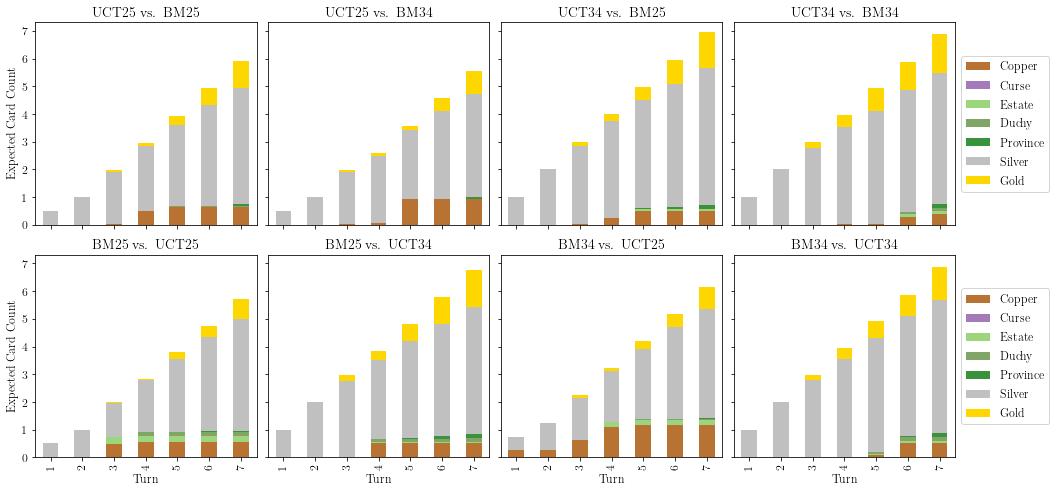

In [38]:
sns.set_palette(sandbox_colors)

data = [[uct25_bm25_cards, uct25_bm34_cards, uct34_bm25_cards, uct34_bm34_cards], [bm25_uct25_cards, bm25_uct34_cards, bm34_uct25_cards, bm34_uct34_cards]]
n, m = len(data), len(data[0])

fig, axes = plt.subplots(n, m, figsize=(16.5, 8), sharex='all', sharey='all')

for i in range(n):
    for j in range(m):
        mean_counts = data[i][j].groupby(['Player', 'Turn']).mean()
        mean_counts['Copper'] -= 7
        mean_counts['Estate'] -=3
        plot_data = mean_counts.loc[idx[i, [1, 2, 3, 4, 5, 6, 7]], :].reset_index().drop(['Iter', 'Player'], axis=1)
        plot_data.plot(x='Turn', kind='bar', stacked='True', legend=None, ax=axes[i, j])
    axes[i, 0].set_ylabel('Expected Card Count')
    axes[i, (m-1)].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

axes[0, 0].set_title('UCT25 vs. BM25')
axes[0, 1].set_title('UCT25 vs. BM34')
axes[0, 2].set_title('UCT34 vs. BM25')
axes[0, 3].set_title('UCT34 vs. BM34')
axes[1, 0].set_title('BM25 vs. UCT25')
axes[1, 1].set_title('BM25 vs. UCT34')
axes[1, 2].set_title('BM34 vs. UCT25')
axes[1, 3].set_title('BM34 vs. UCT34')

fig.subplots_adjust(wspace=0.05, hspace=0.15)
plt.show()

In [39]:
fig.savefig(os.path.join(fig_dir, 's-uct-bm-cards.png'), dpi=dpi)

In [41]:
dataset_name = 'uctlog25-bm25-1k-data'
data_path = os.path.join(project_root, 'data', dataset_name)
uct25log_bm25_data = load(data_path)
uct25log_bm25_turns = uct25log_bm25_data.turn_df
uct25log_bm25_cards = uct25log_bm25_data.card_df

dataset_name = 'uctlog25-bm34-1k-data'
data_path = os.path.join(project_root, 'data', dataset_name)
uct25log_bm34_data = load(data_path)
uct25log_bm34_turns = uct25log_bm34_data.turn_df
uct25log_bm34_cards = uct25log_bm34_data.card_df

dataset_name = 'uctlog34-bm25-1k-data'
data_path = os.path.join(project_root, 'data', dataset_name)
uct34log_bm25_data = load(data_path)
uct34log_bm25_turns = uct34log_bm25_data.turn_df
uct34log_bm25_cards = uct34log_bm25_data.card_df

dataset_name = 'uctlog34-bm34-1k-data'
data_path = os.path.join(project_root, 'data', dataset_name)
uct34log_bm34_data = load(data_path)
uct34log_bm34_turns = uct34log_bm34_data.turn_df
uct34log_bm34_cards = uct34log_bm34_data.card_df

dataset_name = 'bm25-uctlog25-1k-data'
data_path = os.path.join(project_root, 'data', dataset_name)
bm25_uct25log_data = load(data_path)
bm25_uct25log_turns = bm25_uct25log_data.turn_df
bm25_uct25log_cards = bm25_uct25log_data.card_df

dataset_name = 'bm34-uctlog25-1k-data'
data_path = os.path.join(project_root, 'data', dataset_name)
bm34_uct25log_data = load(data_path)
bm34_uct25log_turns = bm34_uct25log_data.turn_df
bm34_uct25log_cards = bm34_uct25log_data.card_df

dataset_name = 'bm25-uctlog34-1k-data'
data_path = os.path.join(project_root, 'data', dataset_name)
bm25_uct34log_data = load(data_path)
bm25_uct34log_turns = bm25_uct34log_data.turn_df
bm25_uct34log_cards = bm25_uct34log_data.card_df

dataset_name = 'bm34-uctlog34-1k-data'
data_path = os.path.join(project_root, 'data', dataset_name)
bm34_uct34log_data = load(data_path)
bm34_uct34log_turns = bm34_uct34log_data.turn_df
bm34_uct34log_cards = bm34_uct34log_data.card_df

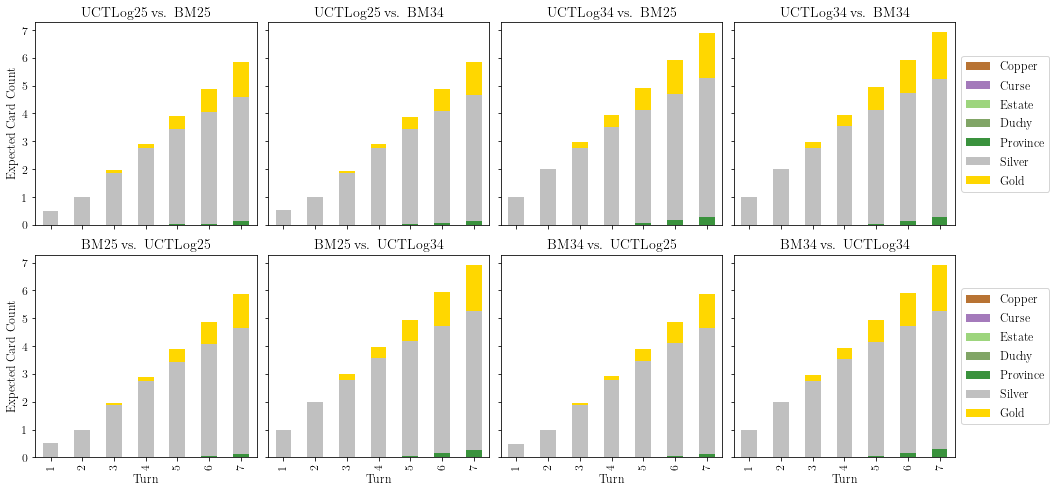

In [42]:
sns.set_palette(sandbox_colors)

data = [[uct25log_bm25_cards, uct25log_bm34_cards, uct34log_bm25_cards, uct34log_bm34_cards], [bm25_uct25log_cards, bm25_uct34log_cards, bm34_uct25log_cards, bm34_uct34log_cards]]
n, m = len(data), len(data[0])

fig, axes = plt.subplots(n, m, figsize=(16.5, 8), sharex='all', sharey='all')

for i in range(n):
    for j in range(m):
        mean_counts = data[i][j].groupby(['Player', 'Turn']).mean()
        mean_counts['Copper'] -= 7
        mean_counts['Estate'] -=3
        plot_data = mean_counts.loc[idx[i, [1, 2, 3, 4, 5, 6, 7]], :].reset_index().drop(['Iter', 'Player'], axis=1)
        plot_data.plot(x='Turn', kind='bar', stacked='True', legend=None, ax=axes[i, j])
    axes[i, 0].set_ylabel('Expected Card Count')
    axes[i, (m-1)].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

axes[0, 0].set_title('UCTLog25 vs. BM25')
axes[0, 1].set_title('UCTLog25 vs. BM34')
axes[0, 2].set_title('UCTLog34 vs. BM25')
axes[0, 3].set_title('UCTLog34 vs. BM34')
axes[1, 0].set_title('BM25 vs. UCTLog25')
axes[1, 1].set_title('BM25 vs. UCTLog34')
axes[1, 2].set_title('BM34 vs. UCTLog25')
axes[1, 3].set_title('BM34 vs. UCTLog34')

fig.subplots_adjust(wspace=0.05, hspace=0.15)
plt.show()

In [43]:
fig.savefig(os.path.join(fig_dir, 'uctlog-bm-cards.png'), dpi=dpi)

In [70]:
sns.color_palette('twilight')

[(0.5383401557517628, 0.677970811290954, 0.7711273443905772),
 (0.37324816143326384, 0.38140848555753937, 0.7059820097480604),
 (0.28669151388283165, 0.08242987384848069, 0.39331182532243375),
 (0.3153587000920581, 0.07942099731524319, 0.2681190407694196),
 (0.6456734938264543, 0.2615520316161528, 0.31248673753935263),
 (0.7904577684772788, 0.5982813427706246, 0.48622257801969754)]

In [7]:
uct25_dw25_turns['Count'] = uct25_dw25_turns.groupby(['Iter', 'Player', 'Card']).cumcount() + 1
uct25_dw34_turns['Count'] = uct25_dw34_turns.groupby(['Iter', 'Player', 'Card']).cumcount() + 1
uct34_dw25_turns['Count'] = uct34_dw25_turns.groupby(['Iter', 'Player', 'Card']).cumcount() + 1
uct34_dw34_turns['Count'] = uct34_dw34_turns.groupby(['Iter', 'Player', 'Card']).cumcount() + 1


In [8]:
uct25_dw25_turns['Game Progress'] = uct25_dw25_turns[['Iter', 'Player', 'Turn']].groupby(['Iter', 'Player']).transform(lambda z: z.div(z.max()))
uct25_dw34_turns['Game Progress'] = uct25_dw34_turns[['Iter', 'Player', 'Turn']].groupby(['Iter', 'Player']).transform(lambda z: z.div(z.max()))
uct34_dw25_turns['Game Progress'] = uct34_dw25_turns[['Iter', 'Player', 'Turn']].groupby(['Iter', 'Player']).transform(lambda z: z.div(z.max()))
uct34_dw34_turns['Game Progress'] = uct34_dw34_turns[['Iter', 'Player', 'Turn']].groupby(['Iter', 'Player']).transform(lambda z: z.div(z.max()))

In [35]:
sns.color_palette('winter')

ValueError: spectral is not a valid palette name

## Big Money ##

In [53]:
dataset_name = 'bm-bm-10k-stats'
data_path = os.path.join(project_root, 'data', dataset_name)
sim_stats = load(data_path)

### Trajectories ###

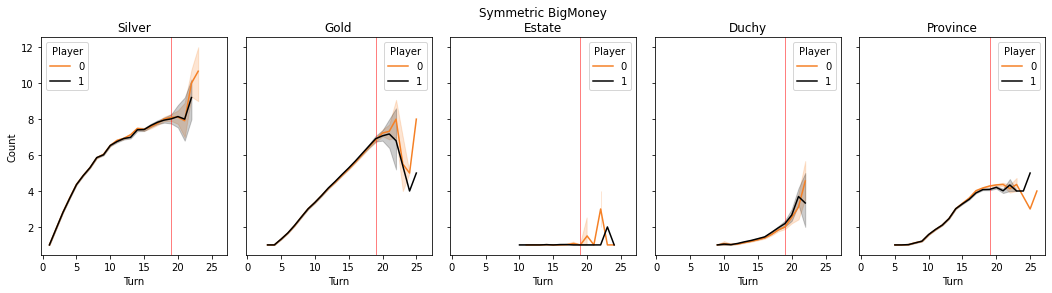

In [65]:
cards = ['Silver', 'Gold', 'Estate', 'Duchy', 'Province']
fig, axes = plt.subplots(1, len(cards), figsize=(18, 4), sharex='all', sharey='all')

game_df = sim_stats.game_df
mu_turns = game_df['Turns'].mean()
sigma_turns = game_df['Turns'].std()

for i, card in enumerate(cards):
    df_select = df[df['Card'] == card]    
    axes[i].axvline(x=mu_turns + sigma_turns, c='r', linewidth=0.5)
    
    if i == 2:
        axes[i].set_title(f'Symmetric BigMoney\n{card}')
    else:
        axes[i].set_title(f'{card}')

    sns.lineplot(x='Turn', y='Count', data=df_select, hue='Player', ax=axes[i], palette=colors)

fig.subplots_adjust(wspace=0.1, hspace=0.3)
plt.show()

In [66]:
fig.savefig(os.path.join(fig_dir, 'bm-trajectories-raw.png'), dpi=300)

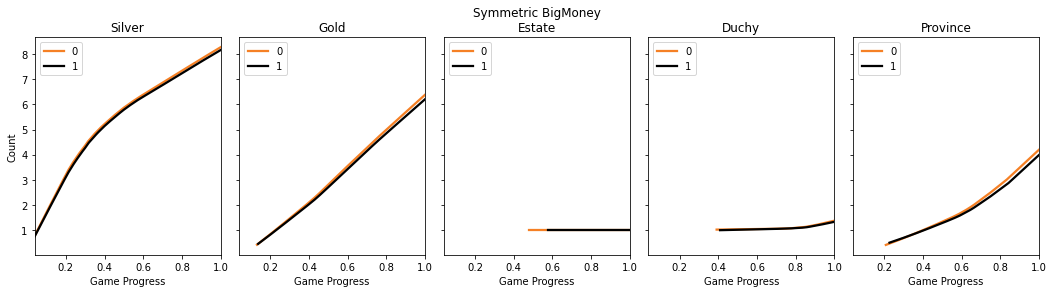

In [67]:
cards = ['Silver', 'Gold', 'Estate', 'Duchy', 'Province']
fig, axes = plt.subplots(1, len(cards), figsize=(18, 4), sharex='all', sharey='all')

# mu_turns = game_df['Turns'].mean()
# sigma_turns = game_df['Turns'].std()

for i, card in enumerate(cards):
    df_select = df[df['Card'] == card]    
    # axes[i].axvline(x=mu_turns + sigma_turns, c='r', linewidth=0.5)
    
    if i == 2:
        axes[i].set_title(f'Symmetric BigMoney\n{card}')
    else:
        axes[i].set_title(f'{card}')

    sns.regplot(x='Game Progress', y='Count', data=df_select[df_select['Player']==0], lowess=True, ax=axes[i], scatter=False, color=colors[0])
    sns.regplot(x='Game Progress', y='Count', data=df_select[df_select['Player']==1], lowess=True, ax=axes[i], scatter=False, color=colors[1])
    axes[i].legend(labels=['0', '1'], loc='upper left')

    if i != 0: 
        axes[i].set_ylabel('')

fig.subplots_adjust(wspace=0.1, hspace=0.3)
plt.show()

In [68]:
fig.savefig(os.path.join(fig_dir, 'bm-trajectories.png'), dpi=300)

## Sandbox ##

### Trajectories ###

In [10]:
dataset_name = 'bm-mlog-10k-data'
data_path = os.path.join(project_root, 'data', dataset_name)
sim_stats = load(data_path)

In [11]:
dataset_name = 'bm-uct-10k-data'
data_path = os.path.join(project_root, 'data', dataset_name)
sim_stats_comp = load(data_path)

In [12]:
mu_turns = sim_stats.game_df['Turns'].mean()
sigma_turns = sim_stats.game_df['Turns'].std()

mu_turns_comp = sim_stats_comp.game_df['Turns'].mean()
sigma_turns_comp = sim_stats_comp.game_df['Turns'].std()

df_comp = sim_stats_comp.turn_df
df_comp['Count'] = df_comp.groupby(['Iter', 'Player', 'Card']).cumcount() + 1

In [13]:
sim_stats.turn_df['Game Progress'] = sim_stats.turn_df[['Iter', 'Player', 'Turn']].groupby(['Iter', 'Player']).transform(lambda z: z.div(z.max()))
df_comp['Game Progress'] = df_comp[['Iter', 'Player', 'Turn']].groupby(['Iter', 'Player']).transform(lambda z: z.div(z.max()))

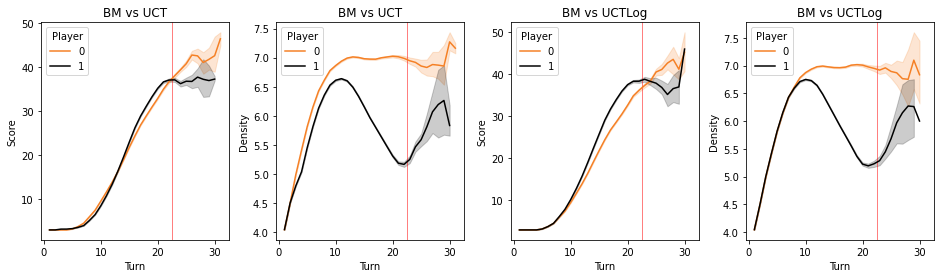

In [15]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharex='all')

axes[0].set_title(f'BM vs UCT')
axes[0].axvline(x=mu_turns + 2 * sigma_turns, c='r', linewidth=0.5)
sns.lineplot(x='Turn', y='Score', data=sim_stats_comp.turn_df, hue='Player', palette=colors, ax=axes[0])

axes[1].set_title(f'BM vs UCT')
axes[1].axvline(x=mu_turns + 2 * sigma_turns, c='r', linewidth=0.5)
sns.lineplot(x='Turn', y='Density', data=sim_stats_comp.turn_df, hue='Player', palette=colors, ax=axes[1])

axes[2].set_title(f'BM vs UCTLog')
axes[2].axvline(x=mu_turns + 2 * sigma_turns, c='r', linewidth=0.5)
sns.lineplot(x='Turn', y='Score', data=sim_stats.turn_df, hue='Player', palette=colors, ax=axes[2])

axes[3].set_title(f'BM vs UCTLog')
axes[3].axvline(x=mu_turns + 2 * sigma_turns, c='r', linewidth=0.5)
sns.lineplot(x='Turn', y='Density', data=sim_stats.turn_df, hue='Player', palette=colors, ax=axes[3])
fig.subplots_adjust(wspace=0.25, hspace=0.25)

plt.show()

In [16]:
fig.savefig(os.path.join(fig_dir, 'bm-uctlog-stats-raw.png'), dpi=300)

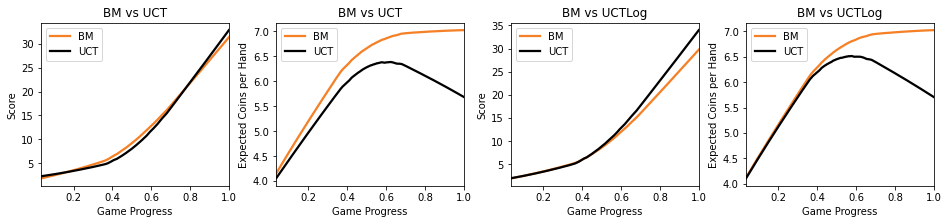

In [17]:
fig, axes = plt.subplots(1, 4, figsize=(16, 3), sharex='all')

df_select = sim_stats_comp.turn_df

axes[0].set_title(f'BM vs UCT')
sns.regplot(x='Game Progress', y='Score', data=df_select[df_select['Player']==0], lowess=True, ax=axes[0], scatter=False, color=colors[0], scatter_kws={'alpha': 0.1, 's': 0.5})
sns.regplot(x='Game Progress', y='Score', data=df_select[df_select['Player']==1], lowess=True, ax=axes[0], scatter=False, color=colors[1], scatter_kws={'alpha': 0.01, 's': 0.5})
axes[0].legend(labels=['BM', 'UCT'], loc='upper left')

axes[1].set_title(f'BM vs UCT')
sns.regplot(x='Game Progress', y='Density', data=df_select[df_select['Player']==0], lowess=True, ax=axes[1], scatter=False, color=colors[0])
sns.regplot(x='Game Progress', y='Density', data=df_select[df_select['Player']==1], lowess=True, ax=axes[1], scatter=False, color=colors[1])
axes[1].set_ylabel('Expected Coins per Hand')
axes[1].legend(labels=['BM', 'UCT'], loc='upper left')

df_select = sim_stats.turn_df
axes[2].set_title(f'BM vs UCTLog')
sns.regplot(x='Game Progress', y='Score', data=df_select[df_select['Player']==0], lowess=True, ax=axes[2], scatter=False, color=colors[0])
sns.regplot(x='Game Progress', y='Score', data=df_select[df_select['Player']==1], lowess=True, ax=axes[2], scatter=False, color=colors[1])
axes[2].legend(labels=['BM', 'UCT'], loc='upper left')

axes[3].set_title(f'BM vs UCTLog')
sns.regplot(x='Game Progress', y='Density', data=df_select[df_select['Player']==0], lowess=True, ax=axes[3], scatter=False, color=colors[0])
sns.regplot(x='Game Progress', y='Density', data=df_select[df_select['Player']==1], lowess=True, ax=axes[3], scatter=False, color=colors[1])
axes[3].set_ylabel('Expected Coins per Hand')
axes[3].legend(labels=['BM', 'UCT'], loc='upper left')
fig.subplots_adjust(wspace=0.25, hspace=0.25)

plt.show()

In [18]:
fig.savefig(os.path.join(fig_dir, 'bm-uctlog-stats.png'), dpi=300)

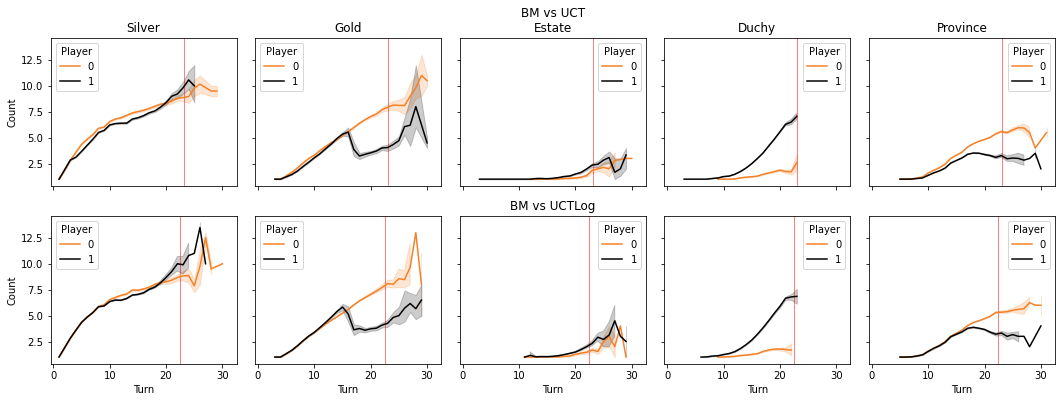

In [18]:
cards = ['Silver', 'Gold', 'Estate', 'Duchy', 'Province']
fig, axes = plt.subplots(2, len(cards), figsize=(18, 6), sharex='all', sharey='all')

for i, card in enumerate(cards):
    df_select = df[df['Card'] == card]    
    df_select_comp = df_comp[df_comp['Card'] == card]

    axes[0,i].axvline(x=mu_turns_comp + 2 *sigma_turns, c='r', linewidth=0.5)
    axes[1,i].axvline(x=mu_turns + 2 * sigma_turns, c='r', linewidth=0.5)
    
    if i == 2:
        axes[0,i].set_title(f'BM vs UCT\n{card}')
        axes[1, i].set_title(f'BM vs UCTLog')
    else:
        axes[0,i].set_title(f'{card}')

    sns.lineplot(x='Turn', y='Count', data=df_select_comp, hue='Player', ax=axes[0,i], palette=colors)  
    sns.lineplot(x='Turn', y='Count', data=df_select, hue='Player', ax=axes[1,i], palette=colors)  

fig.subplots_adjust(wspace=0.1)
plt.show()

In [19]:
fig.savefig(os.path.join(fig_dir, 'bm-uctlog-cards-raw.png'), dpi=300)

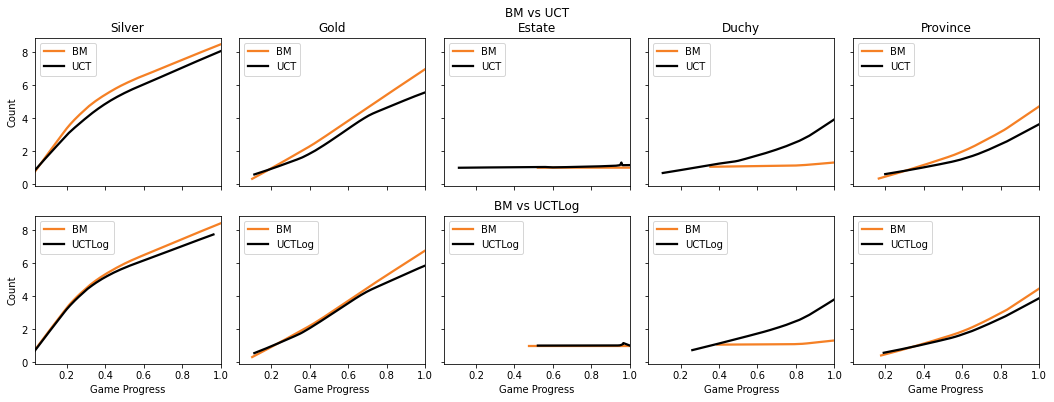

In [85]:
cards = ['Silver', 'Gold', 'Estate', 'Duchy', 'Province']
fig, axes = plt.subplots(2, len(cards), figsize=(18, 6), sharex='all', sharey='all')

for i, card in enumerate(cards):
    df_select = df[df['Card'] == card]    
    df_select_comp = df_comp[df_comp['Card'] == card]
    
    if i == 2:
        axes[0,i].set_title(f'BM vs UCT\n{card}')
        axes[1, i].set_title(f'BM vs UCTLog')
    else:
        axes[0,i].set_title(f'{card}')

    sns.regplot(x='Game Progress', y='Count', data=df_select_comp[df_select_comp['Player']==0], lowess=True, scatter=False, color=colors[0], ax=axes[0, i])
    sns.regplot(x='Game Progress', y='Count', data=df_select_comp[df_select_comp['Player']==1], lowess=True, scatter=False, color=colors[1], ax=axes[0, i])
    axes[0, i].legend(labels=['BM', 'UCT'], loc='upper left') 
    axes[0, i].set_xlabel('')

    sns.regplot(x='Game Progress', y='Count', data=df_select[df_select['Player']==0], lowess=True, scatter=False, color=colors[0], ax=axes[1, i])
    sns.regplot(x='Game Progress', y='Count', data=df_select[df_select['Player']==1], lowess=True, scatter=False, color=colors[1], ax=axes[1, i])
    axes[1, i].legend(labels=['BM', 'UCTLog'], loc='upper left')

    if i != 0: 
        axes[0, i].set_ylabel('')
        axes[1, i].set_ylabel('')

fig.subplots_adjust(wspace=0.1)
plt.show()

In [86]:
fig.savefig(os.path.join(fig_dir, 'bm-uct-no-tree-cards.png'), dpi=300)

## Symmetric DoubleWitch Starting Advantage ##

In [33]:
dataset_name = 'dw25-dw25-10k-stats'
data_path = os.path.join(project_root, 'data', dataset_name)
sim_stats = load(data_path)

In [34]:
action_df = sim_stats.action_df

curse_turns = action_df[['Iter', 'Player', 'Turn']].groupby('Iter').head(10)
witch_turns = action_df[['Iter', 'Player', 'Turn']].groupby(['Iter', 'Player']).count()

p0_curse_turns = curse_turns[curse_turns['Player'] == 0]
p1_curse_turns = curse_turns[curse_turns['Player'] == 1]
p0_witch_turns = witch_turns.loc[idx[:, 0], :].reset_index().set_index('Iter')
p1_witch_turns = witch_turns.loc[idx[:, 1], :].reset_index().set_index('Iter')

In [35]:
dw25_stats = load(os.path.join(project_root, 'data', 'dw25-dw25-10k-stats'))
dw34_stats = load(os.path.join(project_root, 'data', 'dw34-dw34-10k-stats'))

dw25_turns = dw25_stats.turn_df
dw34_turns = dw34_stats.turn_df
dw25_game = dw25_stats.game_df
dw34_game = dw34_stats.game_df
dw25_actions = dw25_stats.action_df
dw34_actions = dw34_stats.action_df 

dw25_turns['Count'] = dw25_turns.groupby(['Iter','Player','Card']).cumcount() + 1
dw34_turns['Count'] = dw34_turns.groupby(['Iter', 'Player', 'Card']).cumcount() + 1

mu_25_turns = dw25_game['Turns'].mean()
sigma_25_turns = dw25_game['Turns'].std()
mu_34_turns = dw34_game['Turns'].mean()
sigma_34_turns = dw34_game['Turns'].std()

dw25_first_witch_turn = dw25_stats.action_df[['Iter', 'Player', 'Turn']].groupby(['Iter', 'Player']).min()
dw34_first_witch_turn = dw34_stats.action_df[['Iter', 'Player', 'Turn']].groupby(['Iter', 'Player']).min()

In [46]:
dw25_turns['Game Progress'] = dw25_turns[['Iter', 'Player', 'Turn']].groupby(['Iter', 'Player']).transform(lambda z: z.div(z.max()))
dw34_turns['Game Progress'] = dw34_turns[['Iter', 'Player', 'Turn']].groupby(['Iter', 'Player']).transform(lambda z: z.div(z.max()))

### Posteriors ###

In [45]:
temp = p0_witch_turns['Turn'] > p1_witch_turns['Turn']
p0_more_witch_idxs = temp[temp == True].index

temp = p0_witch_turns['Turn'] < p1_witch_turns['Turn']
p0_fewer_witch_idxs = temp[temp == True].index

temp = p0_witch_turns['Turn'] == p1_witch_turns['Turn']
p0_eq_witch_idxs = temp[temp == True].index

n_prior = len(p0_more_witch_idxs)
n_wins = len(p0_more_witch_idxs.intersection(p_win_idxs))
n_loss = len(p0_more_witch_idxs.intersection(p_loss_idxs))
print(f'Prior: {n_prior / n * 100:.2f}%')
print(f'P(Win | more Witch turns) = {n_wins / n_prior * 100:.2f}%')
print(f'P(Loss | more Witch turns) = {n_loss / n_prior* 100:.2f}%')
print(f'P(Tie | more Witch turns) = {(n_prior - n_wins - n_loss) / n_prior* 100:.2f}%\n')

n_prior = len(p0_fewer_witch_idxs)
n_wins = len(p0_fewer_witch_idxs.intersection(p_win_idxs))
n_loss = len(p0_fewer_witch_idxs.intersection(p_loss_idxs))
print(f'Prior: {n_prior / n * 100:.2f}%')
print(f'P(Win | fewer Witch turns) = {n_wins / n_prior* 100:.2f}%')
print(f'P(Loss | fewer Witch turns) = {n_loss / n_prior* 100:.2f}%')
print(f'P(Tie | fewer Witch turns) = {(n_prior - n_wins - n_loss) / n_prior* 100:.2f}%\n')

n_prior = len(p0_eq_witch_idxs)
n_wins = len(p0_eq_witch_idxs.intersection(p_win_idxs))
n_loss = len(p0_eq_witch_idxs.intersection(p_loss_idxs))
print(f'Prior: {n_prior / n * 100:.2f}%')
print(f'P(Win | eq Witch turns) = {n_wins / n_prior* 100:.2f}%')
print(f'P(Loss | eq Witch turns) = {n_loss / n_prior* 100:.2f}%')
print(f'P(Tie | eq Witch turns) = {(n_prior - n_wins - n_loss) / n_prior* 100:.2f}%')

NameError: name 'p_win_idxs' is not defined

### Trajectories ###

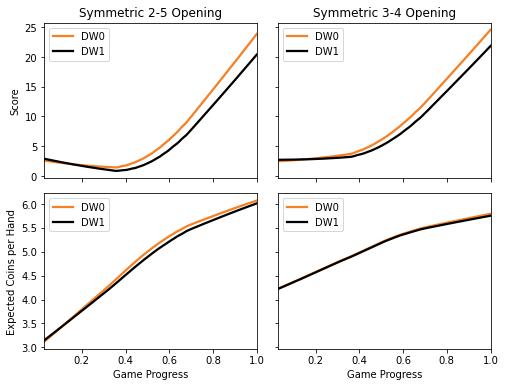

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharex='all', sharey='row')

axes[0, 0].set_title(f'Symmetric 2-5 Opening')
sns.regplot(x='Game Progress', y='Score', data=dw25_turns[dw25_turns['Player']==0], lowess=True, scatter=False, color=colors[0], ax=axes[0, 0])
sns.regplot(x='Game Progress', y='Score', data=dw25_turns[dw25_turns['Player']==1], lowess=True, scatter=False, color=colors[1], ax=axes[0, 0])
axes[0, 0].legend(labels=['DW0', 'DW1'], loc='upper left')
axes[0, 0].set_xlabel('')

axes[0, 1].set_title(f'Symmetric 3-4 Opening')
sns.regplot(x='Game Progress', y='Score', data=dw34_turns[dw34_turns['Player']==0], lowess=True, scatter=False, color=colors[0], ax=axes[0, 1])
sns.regplot(x='Game Progress', y='Score', data=dw34_turns[dw34_turns['Player']==1], lowess=True, scatter=False, color=colors[1], ax=axes[0, 1])
axes[0, 1].legend(labels=['DW0', 'DW1'], loc='upper left')
axes[0, 1].set_xlabel('')
axes[0, 1].set_ylabel('')

sns.regplot(x='Game Progress', y='Density', data=dw25_turns[dw25_turns['Player']==0], lowess=True, scatter=False, color=colors[0], ax=axes[1, 0])
sns.regplot(x='Game Progress', y='Density', data=dw25_turns[dw25_turns['Player']==1], lowess=True, scatter=False, color=colors[1], ax=axes[1, 0])
axes[1, 0].legend(labels=['DW0', 'DW1'], loc='upper left')
axes[1, 0].set_ylabel(f'Expected Coins per Hand')

sns.regplot(x='Game Progress', y='Density', data=dw34_turns[dw34_turns['Player']==0], lowess=True, scatter=False, color=colors[0], ax=axes[1, 1])
sns.regplot(x='Game Progress', y='Density', data=dw34_turns[dw34_turns['Player']==1], lowess=True, scatter=False, color=colors[1], ax=axes[1, 1])
axes[1, 1].legend(labels=['DW0', 'DW1'], loc='upper left')
axes[1, 1].set_ylabel('')

fig.subplots_adjust(wspace=0.1, hspace=0.1)

plt.show()

In [30]:
fig.savefig(os.path.join(fig_dir, 'dw-starting-advantage.png'), dpi=300)

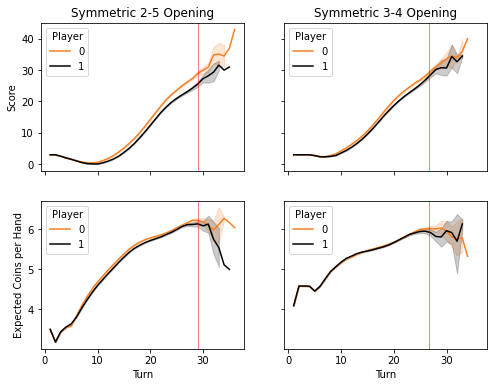

In [42]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharex='all', sharey='row')

sns.lineplot(x='Turn', y='Score', data=dw25_turns, hue='Player', ax=axes[0, 0], palette=colors)
axes[0, 0].set_title(f'Symmetric 2-5 Opening')
axes[0, 0].axvline(x=mu_25_turns + 2 * sigma_25_turns, c='r', linewidth=0.5)
sns.lineplot(x='Turn', y='Score', data=dw34_turns, hue='Player', ax=axes[0, 1], palette=colors)
axes[0, 1].set_title(f'Symmetric 3-4 Opening')
axes[0, 1].axvline(x=mu_34_turns + 2 * sigma_34_turns, c='r', linewidth=0.5)
sns.lineplot(x='Turn', y='Density', data=dw25_turns, hue='Player', ax=axes[1,0], palette=colors)
axes[1, 0].axvline(x=mu_25_turns + 2 * sigma_25_turns, c='r', linewidth=0.5)
sns.lineplot(x='Turn', y='Density', data=dw34_turns, hue='Player', ax=axes[1,1], palette=colors)
axes[1, 1].axvline(x=mu_34_turns + 2 * sigma_34_turns, c='r', linewidth=0.5)
axes[1, 0].set_ylabel(f'Expected Coins per Hand')
plt.show()

In [43]:
fig.savefig(os.path.join(fig_dir, 'dw-starting-advantage-raw.png'), dpi=dpi)

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharex='all', sharey='row')

sns.lineplot(x='Turn', y='Score', data=dw25_turns, hue='Player', ax=axes[0, 0])
axes[0, 0].set_title(f'Symmetric 2-5 Opening')
axes[0, 0].axvline(x=mu_25_turns + 2 * sigma_25_turns, c='r', linewidth=0.5)
sns.lineplot(x='Turn', y='Score', data=dw34_turns, hue='Player', ax=axes[0, 1])
axes[0, 1].set_title(f'Symmetric 3-4 Opening')
axes[0, 1].axvline(x=mu_34_turns + 2 * sigma_34_turns, c='r', linewidth=0.5)
sns.lineplot(x='Turn', y='Density', data=dw25_turns, hue='Player', ax=axes[1,0])
axes[1, 0].axvline(x=mu_25_turns + 2 * sigma_25_turns, c='r', linewidth=0.5)
sns.lineplot(x='Turn', y='Density', data=dw34_turns, hue='Player', ax=axes[1,1])
axes[1, 1].axvline(x=mu_34_turns + 2 * sigma_34_turns, c='r', linewidth=0.5)
axes[1, 0].set_ylabel(f'Expected Coins per Hand')
plt.show()

In [ ]:
fig.savefig(os.path.join(fig_dir, 'dw-starting-advantage.png'), dpi=600)

### First Witch play turn and Curse count difference ###

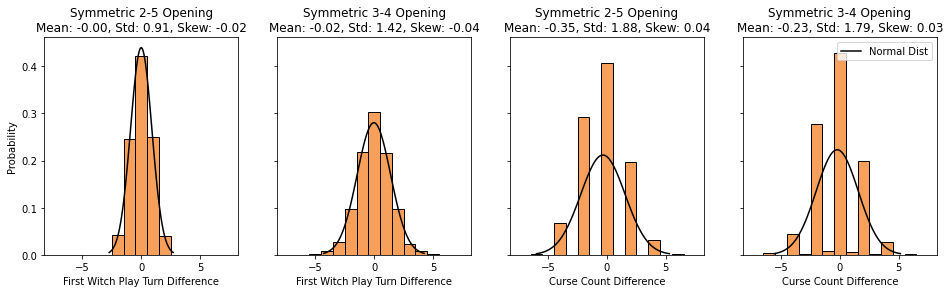

In [40]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharex='all', sharey='all')

p0_dw25_first_witch_turn = dw25_first_witch_turn.loc[idx[:, 0], :].reset_index()
p1_dw25_first_witch_turn = dw25_first_witch_turn.loc[idx[:, 1], :].reset_index()

p0_dw34_first_witch_turn = dw34_first_witch_turn.loc[idx[:, 0], :].reset_index()
p1_dw34_first_witch_turn = dw34_first_witch_turn.loc[idx[:, 1], :].reset_index()

dw25_curse_turns = dw25_actions[['Iter', 'Player', 'Turn']].groupby('Iter').head(10)
dw25_p0_curse_turns = dw25_curse_turns[dw25_curse_turns['Player'] == 0]
dw25_p1_curse_turns = dw25_curse_turns[dw25_curse_turns['Player'] == 1]
dw25_p1_curse_counts = dw25_p0_curse_turns[['Iter', 'Turn']].groupby('Iter').count()
dw25_p0_curse_counts = dw25_p1_curse_turns[['Iter', 'Turn']].groupby('Iter').count()

dw34_curse_turns = dw34_actions[['Iter', 'Player', 'Turn']].groupby('Iter').head(10)
dw34_p0_curse_turns = dw34_curse_turns[dw34_curse_turns['Player'] == 0]
dw34_p1_curse_turns = dw34_curse_turns[dw34_curse_turns['Player'] == 1]
dw34_p1_curse_counts = dw34_p0_curse_turns[['Iter', 'Turn']].groupby('Iter').count()
dw34_p0_curse_counts = dw34_p1_curse_turns[['Iter', 'Turn']].groupby('Iter').count()

data = p0_dw25_first_witch_turn['Turn'] - p1_dw25_first_witch_turn['Turn']
mu = data.mean()
sigma = data.std() 
skew = stats.skew(data)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
normal_dist, = axes[0].plot(x, stats.norm.pdf(x, mu, sigma), blk)
axes[0].set_title(f'Symmetric 2-5 Opening\nMean: {mu:.2f}, Std: {sigma:.2f}, Skew: {skew:.2f}')
axes[0].set_xlabel(f'First Witch Play Turn Difference')
sns.histplot(data=data, stat='probability', discrete=True, ax=axes[0], color=pu_oj)

data = p0_dw34_first_witch_turn['Turn'] - p1_dw34_first_witch_turn['Turn']
mu = data.mean()
sigma = data.std() 
skew = stats.skew(data)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
normal_dist, = axes[1].plot(x, stats.norm.pdf(x, mu, sigma), blk)
axes[1].set_title(f'Symmetric 3-4 Opening\nMean: {mu:.2f}, Std: {sigma:.2f}, Skew: {skew:.2f}')
axes[1].set_xlabel(f'First Witch Play Turn Difference')
sns.histplot(data=data, stat='probability', discrete=True, ax=axes[1], color=pu_oj)

data = dw25_p0_curse_counts['Turn'] - dw25_p1_curse_counts['Turn']
mu = data.mean()
sigma = data.std() 
skew = stats.skew(data)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
normal_dist, = axes[2].plot(x, stats.norm.pdf(x, mu, sigma), blk)
axes[2].set_title(f'Symmetric 2-5 Opening\nMean: {mu:.2f}, Std: {sigma:.2f}, Skew: {skew:.2f}')
axes[2].set_xlabel(f'Curse Count Difference')
sns.histplot(data=data, stat='probability', discrete=True, ax=axes[2], color=pu_oj)

data = dw34_p0_curse_counts['Turn'] - dw34_p1_curse_counts['Turn']
mu = data.mean()
sigma = data.std() 
skew = stats.skew(data)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
normal_dist, = axes[3].plot(x, stats.norm.pdf(x, mu, sigma), blk)
axes[3].set_title(f'Symmetric 3-4 Opening\nMean: {mu:.2f}, Std: {sigma:.2f}, Skew: {skew:.2f}')
axes[3].legend((normal_dist,), ('Normal Dist',))
axes[3].set_xlabel(f'Curse Count Difference')
sns.histplot(data=data, stat='probability', discrete=True, ax=axes[3], color=pu_oj)
plt.show()

In [41]:
fig.savefig(os.path.join(fig_dir, 'dw-symmetric-turn-diff-curse-count.png'), dpi=dpi)

### Extra Turn Posteriors ###

In [31]:
print('All following probabilities refer to starting player.')

n_extra_turn = len(neq_turn_idxs)
n_ties = len(tie_idxs)
n_wins = len(p_win_idxs)
print(f'P(Win) = {(n_wins / n) * 100:.2f}%')
print(f'P(Loss) = {(n - n_wins - n_ties) / n * 100:.2f}%')
print(f'P(Tie) = {n_ties / n * 100:.2f}%\n')

print(f'Starting player gets extra turn (i.e. ends game) {n_extra_turn / n * 100}% of the time.')

p0_win_given_extra_turn = len(p_win_idxs.intersection(neq_turn_idxs))
p0_loss_given_extra_turn = len(p_loss_idxs.intersection(neq_turn_idxs))
p0_tie_given_extra_turn = len(tie_idxs.intersection(neq_turn_idxs))
print(f'P(Wins | Extra Turn) = {p0_win_given_extra_turn / n_extra_turn * 100:.2f}%')
print(f'P(Loses | Extra Turn) = {p0_loss_given_extra_turn / n_extra_turn * 100:.2f}%')
print(f'P(Ties | Extra Turn) = {p0_tie_given_extra_turn / n_extra_turn * 100:.2f}%')

print('')
n_eq_turn = len(eq_turn_idxs)
p0_win_equal_turn = len(p_win_idxs.intersection(eq_turn_idxs))
p0_loss_equal_turn = len(p_loss_idxs.intersection(eq_turn_idxs))
p0_tie_equal_turn = len(tie_idxs.intersection(eq_turn_idxs))
print(f'P(Wins | Equal Turn) = {p0_win_equal_turn / n_eq_turn * 100:.2f}%')
print(f'P(Loses | Equal Turn) = {p0_loss_equal_turn / n_eq_turn * 100:.2f}%')
print(f'P(Ties | Equal Turn) = {p0_tie_equal_turn / n_eq_turn * 100:.2f}%')

All following probabilities refer to starting player.
P(Win) = 56.98%
P(Loss) = 39.48%
P(Tie) = 3.54%

Starting player gets extra turn (i.e. ends game) 50.5% of the time.
P(Wins | Extra Turn) = 67.50%
P(Loses | Extra Turn) = 32.50%
P(Ties | Extra Turn) = 0.00%

P(Wins | Equal Turn) = 46.24%
P(Loses | Equal Turn) = 46.61%
P(Ties | Equal Turn) = 7.15%


### Card Count Evolution ###

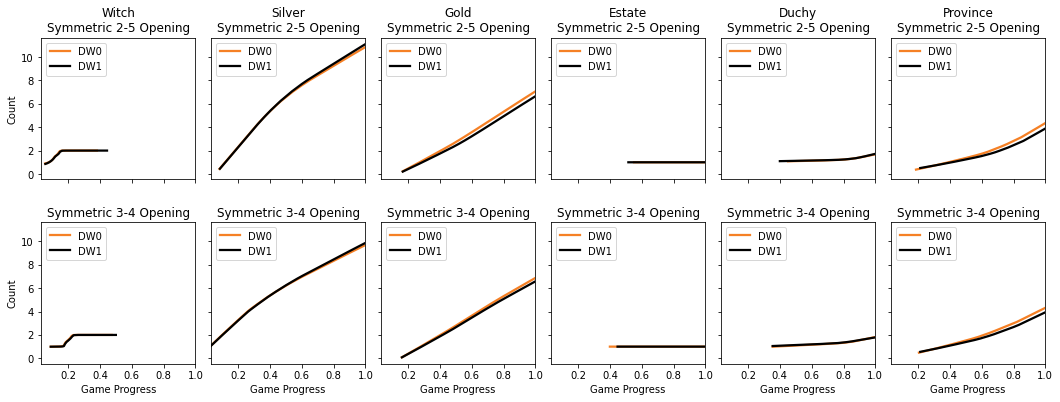

In [49]:
cards = ['Witch', 'Silver', 'Gold', 'Estate', 'Duchy', 'Province']
fig, axes = plt.subplots(2, len(cards), figsize=(18, 6), sharex='all', sharey='all')


for i, card in enumerate(cards):
    df_select = dw25_turns[dw25_turns['Card'] == card]    
    axes[0,i].set_title(f'{card}\nSymmetric 2-5 Opening')
    sns.regplot(x='Game Progress', y='Count', data=df_select[df_select['Player']==0], lowess=True, scatter=False, color=colors[0], ax=axes[0, i])
    sns.regplot(x='Game Progress', y='Count', data=df_select[df_select['Player']==1], lowess=True, scatter=False, color=colors[1], ax=axes[0, i])
    axes[0, i].legend(labels=['DW0', 'DW1'], loc='upper left')

    df_select = dw34_turns[dw34_turns['Card'] == card]    
    axes[1,i].set_title(f'Symmetric 3-4 Opening')
    sns.regplot(x='Game Progress', y='Count', data=df_select[df_select['Player']==0], lowess=True, scatter=False, color=colors[0], ax=axes[1, i])
    sns.regplot(x='Game Progress', y='Count', data=df_select[df_select['Player']==1], lowess=True, scatter=False, color=colors[1], ax=axes[1, i])
    axes[1, i].legend(labels=['DW0', 'DW1'], loc='upper left')
    axes[0, i].set_xlabel('')

    if i != 0: 
        axes[0, i].set_ylabel('')
        axes[1, i].set_ylabel('')

fig.subplots_adjust(wspace=0.1, hspace=0.3)
plt.show()

In [50]:
fig.savefig(os.path.join(fig_dir, 'symmetric-dw-card-counts.png'), dpi=dpi)

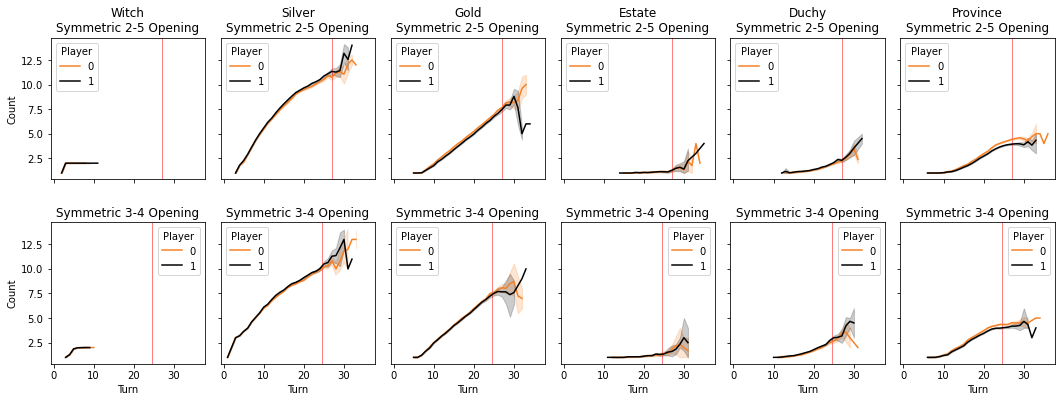

In [51]:
cards = ['Witch', 'Silver', 'Gold', 'Estate', 'Duchy', 'Province']
fig, axes = plt.subplots(2, len(cards), figsize=(18, 6), sharex='all', sharey='all')

dw25_mu_turns = dw25_game['Turns'].mean()
dw25_sigma_turns = dw25_game['Turns'].std()

dw34_mu_turns = dw34_game['Turns'].mean()
dw34_sigma_turns = dw34_game['Turns'].std()

for i, card in enumerate(cards):
    df_select = dw25_turns[dw25_turns['Card'] == card]    
    axes[0,i].set_title(f'{card}\nSymmetric 2-5 Opening')
    axes[0,i].axvline(x=dw25_mu_turns + dw25_sigma_turns, c='r', linewidth=0.5)
    sns.lineplot(x='Turn', y='Count', data=df_select, hue='Player', ax=axes[0,i], palette=colors)  

    df_select = dw34_turns[dw34_turns['Card'] == card]    
    axes[1,i].set_title(f'Symmetric 3-4 Opening')
    axes[1,i].axvline(x=dw34_mu_turns + dw34_sigma_turns, c='r', linewidth=0.5)
    sns.lineplot(x='Turn', y='Count', data=df_select, hue='Player', ax=axes[1,i], palette=colors)  
fig.subplots_adjust(wspace=0.1, hspace=0.3)
plt.show()

In [52]:
fig.savefig(os.path.join(fig_dir, 'symmetric-dw-card-counts-raw.png'), dpi=dpi)